# Import data and display environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# unzip dataset
!unzip /content/drive/MyDrive/COMP5328-A2/datasets.zip -d ./datasets

Archive:  /content/drive/MyDrive/COMP5328-A2/datasets.zip
  inflating: ./datasets/CIFAR.npz    
  inflating: ./datasets/FashionMNIST0.5.npz  
  inflating: ./datasets/FashionMNIST0.6.npz  


In [ ]:
# show RAM info
!free -m -h

              total        used        free      shared  buff/cache   available
Mem:            12G        2.6G        8.3G        1.2M        1.8G         10G
Swap:            0B          0B          0B


In [ ]:
# display CPU info
!cat /proc/cpuinfo

processor	: 0
vendor_id	: AuthenticAMD
cpu family	: 23
model		: 49
model name	: AMD EPYC 7B12
stepping	: 0
microcode	: 0x1000065
cpu MHz		: 2250.000
cache size	: 512 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid tsc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw topoext ssbd ibrs ibpb stibp vmmcall fsgsbase tsc_adjust bmi1 avx2 smep bmi2 rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 clzero xsaveerptr arat npt nrip_save umip rdpid
bugs		: sysret_ss_attrs null_seg spectre_v1 spectre_v2 spec_store_bypass retbleed
bogomips	: 4500.00
TLB si

In [ ]:
# display Python environment
!pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.3.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.2.0
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
asynctest                     0.13.0
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.10.3
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.9
bokeh

# Initial setting

## Import packages

In [ ]:
import os
import copy
import random
import numpy as np
import pandas as pd
from collections import OrderedDict
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.models
import torchvision.transforms

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
cifar_path = "./datasets/CIFAR.npz"
fmnist05_path = "./datasets/FashionMNIST0.5.npz"
fmnist06_path = "./datasets/FashionMNIST0.6.npz"

T_matrix = {"CIFAR": None,
       "FasionMNIST_05": np.array([[0.5, 0.2, 0.3], [0.3, 0.5, 0.2], [0.2, 0.3, 0.5]]),
       "FasionMNIST_06": np.array([[0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.3, 0.3, 0.4]])}



## Data exploration

In [ ]:
# load data
CIFAR = np.load(cifar_path)
FasionMNIST_05 = np.load(fmnist05_path)
FasionMNIST_06 = np.load(fmnist06_path)

In [ ]:
# show data shape
Xtr_val = FasionMNIST_05['Xtr']
Str_val = FasionMNIST_05['Str']
Xts = FasionMNIST_05['Xts']
Yts = FasionMNIST_05['Yts']

print(Xtr_val.shape)
print(Str_val.shape)
print(Xts.shape)
print(Yts.shape)

(18000, 28, 28)
(18000,)
(3000, 28, 28)
(3000,)


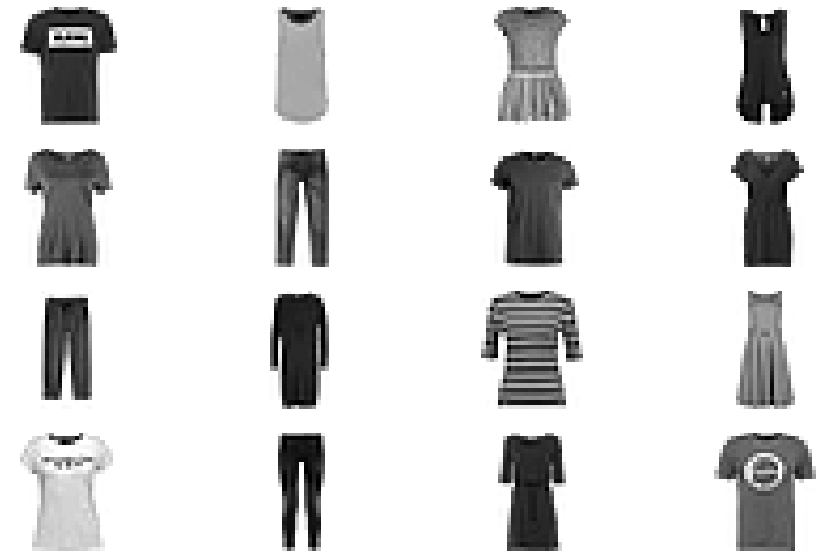

In [ ]:
# show some image samples
sample_data = FasionMNIST_05['Xtr'][:16]
f, ax = plt.subplots(4,4, figsize=(16,10))
for i, img in enumerate(sample_data):
    img = img * 255.0     # unnormalize
    # npimg = img.numpy()
    ax[i//4, i%4].imshow(img, cmap='binary')
    ax[i//4, i%4].axis('off')
plt.show()

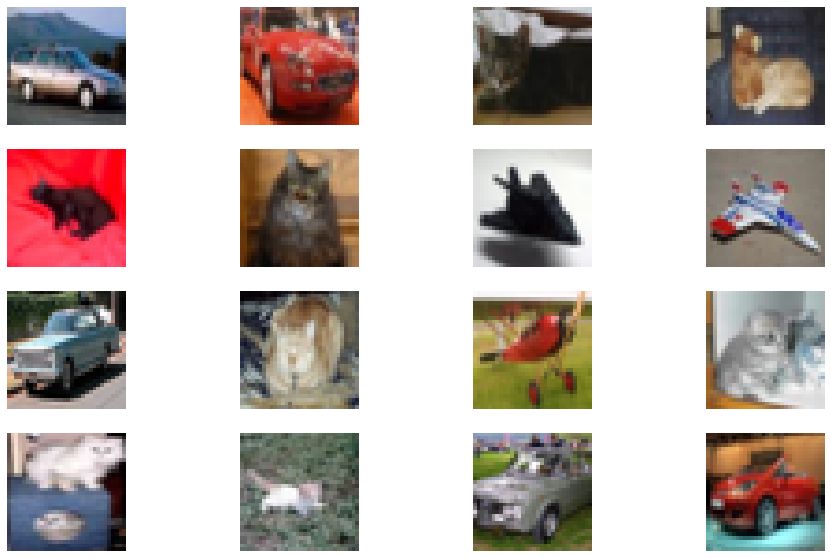

In [ ]:
# show some image samples
sample_data = CIFAR['Xtr'][:16]
f, ax = plt.subplots(4,4, figsize=(16,10))
for i, img in enumerate(sample_data):
    img = img     # unnormalize
    # npimg = img.numpy()
    ax[i//4, i%4].imshow(img)
    ax[i//4, i%4].axis('off')
plt.show()

## Define data loader

In [ ]:
# A helper class, it is used as an input of the DataLoader object.
class DatasetArray(Dataset):
    r"""This is a child class of the pytorch Dataset object."""
    def __init__(self, data, labels=None, transform=None):
        if list(labels) != None:
          data = np.asarray(data).astype(np.float32)
          if len(data.shape)==3:
            self.data_arr = np.expand_dims(data, axis=1)/255.0
          if len(data.shape)==4:
            self.data_arr = np.transpose(data, axes=[0, 3, 1, 2])/255.0
          self.label_arr = np.asarray(labels).astype(np.compat.long)
        else:
            tmp_arr = np.asarray(data)
            self.data_arr = tmp_arr[:,:-1].astype(np.float32)
            self.label_arr = tmp_arr[:,-1].astype(np.compat.long)
        self.transform = transform
        
    def __len__(self):
        return len(self.data_arr)
    
    def __getitem__(self, index):
     
        data = self.data_arr[index]
        label = self.label_arr[index]
        
        if self.transform is not None:
            data = self.transform(data)
            
        return (data, label)

In [ ]:
# Preparation of the data for training, validation and testing a pytorch network. 
# Note that the test data is not in use for this lab.
def get_loader(batch_size =64, num_workers = 1, val_split = 0.2, data=None):
    r"""This function is used to read the data file and split the data into three subsets, i.e, 
    train data, validation data and test data. Their corresponding DataLoader objects are returned."""
    
    train_data_x, val_data_x, train_data_y, val_data_y = train_test_split(data['Xtr'], data['Str'], test_size=val_split, shuffle=True)

    train_data = DatasetArray(data=train_data_x, labels=train_data_y)
    val_data = DatasetArray(data=val_data_x, labels=val_data_y)
    test_data = DatasetArray(data=data['Xts'], labels=data['Yts'])

    #The pytorch built-in class DataLoader can help us to shuffle the data, draw mini-batch,
    #do transformations, etc. 
    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_loader = DataLoader(
        val_data,
        batch_size=100,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        test_data,
        batch_size=100,
        num_workers=num_workers,
        shuffle=False,
    )
    return train_loader, val_loader, test_loader

# Define classifiers

## Define FCN classifier

In [ ]:
# Define a fully connected network class.
class FCNet(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=100, output_dim=3):
        super(FCNet, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # TODO based on the class attributes (fields), define a fully connected network with one hidden layer.
        # Specifically, it should have this structure:
        # input_layer->relu->hidden_layer->relu->output_layer.
        out = F.relu(self.input_layer(x.reshape(-1, 28*28)))
        out = F.relu(self.hidden_layer(out))
        out = self.output_layer(out)
        return out
        
    
def Predefined_FCNet(input_dim=28*28, hidden_dim=256, output_dim=3):
    model = FCNet(input_dim=input_dim,hidden_dim=hidden_dim,output_dim=output_dim)
    return model



## Define CNN classifier

In [ ]:
# Define a CNN network class.
class CNNNet(nn.Module):
    def __init__(self, input_dim=1, output_dim=3):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def Predefined_CNNNet(input_dim=1, output_dim=3):
    model = CNNNet(input_dim=input_dim, output_dim=output_dim)
    return model


# Training and validation

### Define some helper functions for training and validation 

In [ ]:
# When all random seeds are fixed, the python runtime environment becomes deterministic.
def seed_torch(seed=1029):
    r"""Fix all random seeds for repeating the expriement result."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # If multi-GPUs are used. 
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


# Calcuate the accuracy according to the prediction and the true label.
def accuracy(output, target, topk=(1,)):
    r"""Computes the precision@k for the specified values of k."""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


# A helper function which is used to record the experiment results.
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num):
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count
        
        
# Load a NN model.
def load_model(m_config):
    model = globals()[m_config['model_name']]()
    return model



### Define training and validation functions

In [ ]:
# define training function
def train(epoch, model, optimizer, criterion, train_loader):
    """Training a pytorch nn_model."""
    top1_acc_meter = AverageMeter()
    loss_meter = AverageMeter()

    # swith model to to train mode
    model.train()
    for step, (data, targets) in enumerate(train_loader):
        # prepare min_batch
        data = data.to(device)
        targets = targets.to(device)

        # predict
        preds = model(data)

        # forward
        loss = criterion(preds, targets)

        # set all gradients to zero
        optimizer.zero_grad()

        # backward
        loss.backward()

        # update all gradients
        optimizer.step()

        # calculate accuracy
        [top1_acc] = accuracy(preds.data, targets.data, topk=(1,))
        # record accuary and cross entropy losss
        min_batch_size = data.size(0)
        top1_acc_meter.update(top1_acc.item(), min_batch_size)
        loss_meter.update(loss.item(), min_batch_size)

    print("Train epoch ",epoch," Accuracy ",top1_acc_meter.avg)
    
# function for validation    
def validate_and_test(epoch, model, criterion, val_loader, is_test=False):
    """Validation or testing of a nn_model."""
    top1_acc_meter = AverageMeter()
    loss_meter = AverageMeter()

    # swith model to to eval mode
    model.eval()
    for step, (data, targets) in enumerate(val_loader):
        # prepare min_batch
        data = data.to(device)
        targets = targets.to(device)

        # predict
        with torch.no_grad():
            preds = model(data)

        # forward
        loss = criterion(preds, targets)
            
        # calculate accuracy
        [top1_acc] = accuracy(preds.data, targets.data, topk=(1,))
  
        # record accuary and cross entropy losss
        min_batch_size = data.size(0)
        top1_acc_meter.update(top1_acc.item(), min_batch_size)
        loss_meter.update(loss.item(), min_batch_size)

    top1_acc_avg = top1_acc_meter.avg
    if(is_test == False):
        print("Validate epoch ",epoch," Accuracy ",top1_acc_avg)
    else:
        print("Test epoch ",epoch," Accuracy ",top1_acc_avg)

    return top1_acc_avg

# main function for training and validation
def run_train_val():
    global device
    global config
    global train_loader
    global test_loader
    global model
    best_top1_acc = 0
    # check gpu
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # configerations
    run_config = config['run_config']
    optim_config = config['optim_config']
    data_config = config['data_config']
    
    # set random seed
    # seed_torch(run_config['seed'])

    # create output directory
    outdir = run_config['outdir']
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # load data
    data = np.load(data_config["data_path"])
    
    train_loader, val_loader, test_loader = get_loader(
        batch_size = optim_config['batch_size'], 
        num_workers = run_config['num_workers'],
        val_split = data_config['val_split'],
        data = data
    )
    
    # model
    model = load_model(config['model_config'])
    if torch.cuda.device_count() > 1:
        print(torch.cuda.device_count(), "GPUs are used!")
        model = nn.DataParallel(model)
    model.to(device)

    # criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        params = model.parameters(),
        lr = optim_config['base_lr'], 
        momentum = optim_config['momentum'],
        weight_decay = optim_config['weight_decay']
    )

    for epoch in range(1, optim_config['epochs'] + 1):

        #train
        train(epoch, model, optimizer, criterion, train_loader)

        #validation
        top1_acc_avg = validate_and_test(epoch, model, criterion, val_loader)
        
        # save the best model so far
        if (top1_acc_avg > best_top1_acc):
            state = OrderedDict([
                ('config', config),
                ('state_dict', model.state_dict()),
                ('optimizer', optimizer.state_dict()),
                ('epoch', epoch),
                ('top1-accuracy', top1_acc_avg),
            ])
            best_model_path = os.path.join(outdir, 'model_best.pth')
            torch.save(state, best_model_path)
            best_top1_acc = top1_acc_avg
            
# load model and predict results            
def predict():
  global config
  global test_loader
  global model
  model.load_state_dict(torch.load(os.path.join(config['run_config']['outdir'], 'model_best.pth'))["state_dict"])
  model.eval()
  y_true = torch.tensor([], dtype=torch.long, device=device)
  all_outputs = torch.tensor([], device=device)
  for step, (data, targets) in enumerate(test_loader):
      
    # TODO Please complete this function.
    data = data.to(device)
    labels = targets.to(device)

    with torch.no_grad():
        outputs = model(data)
    y_true = torch.cat((y_true, labels), 0)
    all_outputs = torch.cat((all_outputs, outputs), 0)
  
  outputs = F.softmax(all_outputs, dim=1).cpu().data.numpy()
  y_true = y_true.cpu().numpy()
  
  _, y_pred = torch.max(all_outputs, 1)
  y_pred = y_pred.cpu().numpy()
  acc = sum(y_true == y_pred)/len(y_pred)
  return outputs, y_true, y_pred, acc

# define the trainsition matrix estimator
def estimate_tmatrix(num_classes, outputs, y_pred):
  """
  Function to estimate the transition matrix based on the noisy class posterior

  :param num_classes: Number of classes
  :param outputs: Outputs from the softmax function
  :param y_pred: Prediction values
  :param average: Average the probabilities for each layer P(Y^{~}=i | x)
  :return T: Estimated transition matrix
  """

  T = np.empty((num_classes, num_classes))
  # Iterate over the number of classes
  for i in range(num_classes):
    # Average the probability per column
    # Get the samples with this predicted class
    # Get the samples of these indexes P(Y^=i | X=Xi)
    Xi_outputs = outputs[(y_pred == i)]

    T[i, :] = np.mean(Xi_outputs, axis=0)

  return T




# Train FCN and CNN classifier on Fasion Mnist05 Dataset

## Train and valid with FCN classifier

In [ ]:
# Some global variabiles
data_path = fmnist05_path
device = None
train_loader = None
model = None
model_config = OrderedDict([
    ('model_name','Predefined_FCNet')
])

optim_config = OrderedDict([
    ('epochs', 20),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])


run_config = OrderedDict([
    ('seed', 1),
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])

run_train_val()


Train epoch  1  Accuracy  45.104166666666664
Validate epoch  1  Accuracy  46.25
Train epoch  2  Accuracy  47.729166666666664
Validate epoch  2  Accuracy  46.5
Train epoch  3  Accuracy  48.104166666666664
Validate epoch  3  Accuracy  46.77777777777778
Train epoch  4  Accuracy  48.229166666666664
Validate epoch  4  Accuracy  46.72222222222222
Train epoch  5  Accuracy  48.333333333333336
Validate epoch  5  Accuracy  47.138888888888886
Train epoch  6  Accuracy  48.736111111111114
Validate epoch  6  Accuracy  47.22222222222222
Train epoch  7  Accuracy  48.708333333333336
Validate epoch  7  Accuracy  47.111111111111114
Train epoch  8  Accuracy  48.86805555555556
Validate epoch  8  Accuracy  47.111111111111114
Train epoch  9  Accuracy  49.041666666666664
Validate epoch  9  Accuracy  46.19444444444444
Train epoch  10  Accuracy  49.1875
Validate epoch  10  Accuracy  47.333333333333336
Train epoch  11  Accuracy  49.1875
Validate epoch  11  Accuracy  47.361111111111114
Train epoch  12  Accuracy  

## Evaluate and estimate the transition matrix

In [ ]:
outputs, y_true, y_pred, acc = predict()
print(f"\nAccuracy: {acc}")

# Using average
estimated_T = estimate_tmatrix(num_classes=3, 
                outputs=outputs, 
                y_pred=y_pred, average=True)

print(f"Transition Matrix: \n{np.round(T_matrix['FasionMNIST_05'], 4)}")
print(f"Estimated Transition Matrix: \n{np.round(estimated_T, 4)}")

# Calculate differences between estimated_T_argmax and T_true
error = np.sum(np.abs(estimated_T-T_matrix['FasionMNIST_05'])) / np.sum(np.abs(T_matrix['FasionMNIST_05']))

print(f"Error: {error}")


Accuracy: 0.9283333333333333
Transition Matrix: 
[[0.5 0.2 0.3]
 [0.3 0.5 0.2]
 [0.2 0.3 0.5]]
Estimated Transition Matrix: 
[[0.5145 0.3096 0.1759]
 [0.1809 0.5586 0.2605]
 [0.2627 0.2073 0.53  ]]
Error: 0.2239104072252909


## Train and valid with CNN classifier

In [ ]:
# Some global variabiles
data_path = fmnist05_path
device = None
train_loader = None
model = None
model_config = OrderedDict([
    ('model_name','Predefined_CNNNet')
])

optim_config = OrderedDict([
    ('epochs', 20),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])


run_config = OrderedDict([
    ('seed', 1),
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])

run_train_val()



Train epoch  1  Accuracy  37.0
Validate epoch  1  Accuracy  43.97222222222222
Train epoch  2  Accuracy  43.111111111111114
Validate epoch  2  Accuracy  40.19444444444444
Train epoch  3  Accuracy  45.38194444444444
Validate epoch  3  Accuracy  47.083333333333336
Train epoch  4  Accuracy  47.03472222222222
Validate epoch  4  Accuracy  47.27777777777778
Train epoch  5  Accuracy  47.458333333333336
Validate epoch  5  Accuracy  47.611111111111114
Train epoch  6  Accuracy  47.576388888888886
Validate epoch  6  Accuracy  47.666666666666664
Train epoch  7  Accuracy  47.6875
Validate epoch  7  Accuracy  47.94444444444444
Train epoch  8  Accuracy  47.84722222222222
Validate epoch  8  Accuracy  48.0
Train epoch  9  Accuracy  48.03472222222222
Validate epoch  9  Accuracy  47.861111111111114
Train epoch  10  Accuracy  48.09027777777778
Validate epoch  10  Accuracy  48.138888888888886
Train epoch  11  Accuracy  48.11805555555556
Validate epoch  11  Accuracy  48.44444444444444
Train epoch  12  Accura

## Evaluate and estimate the transition matrix

In [ ]:
outputs, y_true, y_pred, acc = predict()
print(f"\nAccuracy: {acc}")


Accuracy: 0.9293333333333333


In [ ]:
# Using average
estimated_T = estimate_tmatrix(num_classes=3, 
                outputs=outputs, 
                y_pred=y_pred, average=True)

print(f"Transition Matrix: \n{np.round(T_matrix['FasionMNIST_05'], 4)}")
print(f"Estimated Transition Matrix: \n{np.round(estimated_T, 4)}")

# Calculate differences between estimated_T_argmax and T_true
error = np.sum(np.abs(estimated_T-T_matrix['FasionMNIST_05'])) / np.sum(np.abs(T_matrix['FasionMNIST_05']))

print(f"Error: {error}")

Transition Matrix: 
[[0.5 0.2 0.3]
 [0.3 0.5 0.2]
 [0.2 0.3 0.5]]
Estimated Transition Matrix: 
[[0.4625 0.2984 0.2392]
 [0.2135 0.486  0.3005]
 [0.3    0.2249 0.4751]]
Error: 0.19929679334163664


# Train FCN and CNN classifier on Fasion Mnist06 Dataset


## Train and valid with FCN classifier

In [ ]:
# Some global variabiles
data_path = fmnist06_path
device = None
train_loader = None
model = None
model_config = OrderedDict([
    ('model_name','Predefined_FCNet')
])


optim_config = OrderedDict([
    ('epochs', 20),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])


run_config = OrderedDict([
    ('seed', 1),
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])

run_train_val()



Train epoch  1  Accuracy  37.201388888888886
Validate epoch  1  Accuracy  37.333333333333336
Train epoch  2  Accuracy  38.8125
Validate epoch  2  Accuracy  37.47222222222222
Train epoch  3  Accuracy  39.09027777777778
Validate epoch  3  Accuracy  37.19444444444444
Train epoch  4  Accuracy  39.43055555555556
Validate epoch  4  Accuracy  37.083333333333336
Train epoch  5  Accuracy  39.451388888888886
Validate epoch  5  Accuracy  38.361111111111114
Train epoch  6  Accuracy  39.5625
Validate epoch  6  Accuracy  38.361111111111114
Train epoch  7  Accuracy  40.09027777777778
Validate epoch  7  Accuracy  38.02777777777778
Train epoch  8  Accuracy  40.11805555555556
Validate epoch  8  Accuracy  38.388888888888886
Train epoch  9  Accuracy  39.791666666666664
Validate epoch  9  Accuracy  37.916666666666664
Train epoch  10  Accuracy  40.09027777777778
Validate epoch  10  Accuracy  38.44444444444444
Train epoch  11  Accuracy  40.111111111111114
Validate epoch  11  Accuracy  38.52777777777778
Train

## Evaluate and estimate the transition matrix

In [ ]:
outputs, y_true, y_pred, acc = predict()
print(f"\nAccuracy: {acc}")


Accuracy: 0.8176666666666667


In [ ]:
# Using average
estimated_T = estimate_tmatrix(num_classes=3, 
                outputs=outputs, 
                y_pred=y_pred, average=True)

print(f"Transition Matrix: \n{np.round(T_matrix['FasionMNIST_06'], 4)}")
print(f"Estimated Transition Matrix: \n{np.round(estimated_T, 4)}")

# Calculate differences between estimated_T_argmax and T_true
error = np.sum(np.abs(estimated_T-T_matrix['FasionMNIST_06'])) / np.sum(np.abs(T_matrix['FasionMNIST_06']))

print(f"Error: {error}")

Transition Matrix: 
[[0.4 0.3 0.3]
 [0.3 0.4 0.3]
 [0.3 0.3 0.4]]
Estimated Transition Matrix: 
[[0.381  0.2948 0.3242]
 [0.3067 0.3822 0.3111]
 [0.3143 0.2939 0.3918]]
Error: 0.03750643332799279


## Train and valid with CNN classifier

In [ ]:
# Some global variabiles
data_path = fmnist06_path
device = None
train_loader = None
model = None
model_config = OrderedDict([
    ('model_name','Predefined_CNNNet')
])

optim_config = OrderedDict([
    ('epochs', 20),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])


run_config = OrderedDict([
    ('seed', 1),
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])
            
run_train_val()



Train epoch  1  Accuracy  34.201388888888886
Validate epoch  1  Accuracy  33.47222222222222
Train epoch  2  Accuracy  35.15277777777778
Validate epoch  2  Accuracy  35.888888888888886
Train epoch  3  Accuracy  35.333333333333336
Validate epoch  3  Accuracy  36.916666666666664
Train epoch  4  Accuracy  36.986111111111114
Validate epoch  4  Accuracy  35.833333333333336
Train epoch  5  Accuracy  38.03472222222222
Validate epoch  5  Accuracy  38.69444444444444
Train epoch  6  Accuracy  38.77777777777778
Validate epoch  6  Accuracy  38.583333333333336
Train epoch  7  Accuracy  38.854166666666664
Validate epoch  7  Accuracy  37.888888888888886
Train epoch  8  Accuracy  38.40277777777778
Validate epoch  8  Accuracy  38.666666666666664
Train epoch  9  Accuracy  38.90972222222222
Validate epoch  9  Accuracy  39.55555555555556
Train epoch  10  Accuracy  39.291666666666664
Validate epoch  10  Accuracy  39.02777777777778
Train epoch  11  Accuracy  39.423611111111114
Validate epoch  11  Accuracy  3

## Evaluate and estimate the transition matrix

In [ ]:
outputs, y_true, y_pred, acc = predict()
print(f"\nAccuracy: {acc}")

# Using average
estimated_T = estimate_tmatrix(num_classes=3, 
                outputs=outputs, 
                y_pred=y_pred, average=True)

print(f"Transition Matrix: \n{np.round(T_matrix['FasionMNIST_06'], 4)}")
print(f"Estimated Transition Matrix: \n{np.round(estimated_T, 4)}")

# Calculate differences between estimated_T_argmax and T_true
error = np.sum(np.abs(estimated_T-T_matrix['FasionMNIST_06'])) / np.sum(np.abs(T_matrix['FasionMNIST_06']))

print(f"Error: {error}")


Accuracy: 0.88
Transition Matrix: 
[[0.4 0.3 0.3]
 [0.3 0.4 0.3]
 [0.3 0.3 0.4]]
Estimated Transition Matrix: 
[[0.3904 0.3079 0.3017]
 [0.2995 0.3917 0.3088]
 [0.3046 0.3224 0.373 ]]
Error: 0.030334105094273926


# Estimate unknown T-matrix for Cifar Dataset with CNN classifier

## Define CNN network for Cifar dataset

In [ ]:
# Define a CNN network class.
class CNNNet_color(nn.Module):
    def __init__(self, input_dim=1, output_dim=3):
        super(CNNNet_color, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def Predefined_CNNNet_color(input_dim=3, output_dim=3):
    model = CNNNet_color(input_dim=input_dim, output_dim=output_dim)
    return model

## Train and valid with CNN classifier

In [ ]:
# Some global variabiles
data_path = cifar_path
device = None
train_loader = None
model = None
seed_torch(1)

model_config = OrderedDict([
    ('model_name','Predefined_CNNNet_color'),
    ('input_dim',3)
])

optim_config = OrderedDict([
    ('epochs', 20),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])


run_config = OrderedDict([
    ('seed', 1),
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])
            
run_train_val()



Train epoch  1  Accuracy  34.45
Validate epoch  1  Accuracy  33.166666666666664
Train epoch  2  Accuracy  34.2
Validate epoch  2  Accuracy  36.733333333333334
Train epoch  3  Accuracy  35.325
Validate epoch  3  Accuracy  35.2
Train epoch  4  Accuracy  35.641666666666666
Validate epoch  4  Accuracy  35.5
Train epoch  5  Accuracy  34.85
Validate epoch  5  Accuracy  35.7
Train epoch  6  Accuracy  35.68333333333333
Validate epoch  6  Accuracy  36.46666666666667
Train epoch  7  Accuracy  36.891666666666666
Validate epoch  7  Accuracy  37.833333333333336
Train epoch  8  Accuracy  36.725
Validate epoch  8  Accuracy  37.3
Train epoch  9  Accuracy  36.891666666666666
Validate epoch  9  Accuracy  37.6
Train epoch  10  Accuracy  37.5
Validate epoch  10  Accuracy  36.53333333333333
Train epoch  11  Accuracy  37.43333333333333
Validate epoch  11  Accuracy  35.233333333333334
Train epoch  12  Accuracy  36.975
Validate epoch  12  Accuracy  37.166666666666664
Train epoch  13  Accuracy  37.058333333333

## Evaluate and estimate the transition matrix

In [ ]:
outputs, y_true, y_pred, acc = predict()
print(f"\nAccuracy: {acc}")

# Using average
estimated_T_cifar = estimate_tmatrix(num_classes=3, 
                outputs=outputs, 
                y_pred=y_pred, average=True)

print(f"Estimated Transition Matrix: \n{np.round(estimated_T, 4)}")



Accuracy: 0.6403333333333333
Estimated Transition Matrix: 
[[0.5145 0.3096 0.1759]
 [0.1809 0.5586 0.2605]
 [0.2627 0.2073 0.53  ]]


# Train forward using CNN classifier

## Train on Cifar dataset

In [ ]:
n_iters = 10
test_acc_forward_results = {'cifar': [],
              'fashionmnist0.5': [],
              'fashionmnist0.6': []}

In [ ]:
def Predefined_CNNNet_forward(input_dim=3, output_dim=3):
    model = CNNNet_color(input_dim=input_dim, output_dim=output_dim)
    return model


def train_forward(epoch, model, optimizer, T_mat, criterion, train_loader):
    """Training a pytorch nn_model."""
    top1_acc_meter = AverageMeter()
    loss_meter = AverageMeter()

    T_mat = torch.from_numpy(T_mat).float()
    # swith model to to train mode
    model.train()
    for step, (data, targets) in enumerate(train_loader):
        # prepare min_batch
        data = data.to(device)
        targets = targets.to(device)


        out = model(data)
        # out, revision = model(data)
        loss = criterion(out, targets)
        # loss = criterion(out, T_mat, targets, revision)
        prob = F.softmax(out, dim=1)
        out = torch.matmul((T_mat).t(), prob.t())
        preds = out.t()

        # set all gradients to zero
        optimizer.zero_grad()

        # backward
        loss.backward()

        # update all gradients
        optimizer.step()

        # calculate accuracy
        [top1_acc] = accuracy(preds.data, targets.data, topk=(1,))
        # record accuary and cross entropy losss
        min_batch_size = data.size(0)
        top1_acc_meter.update(top1_acc.item(), min_batch_size)
        loss_meter.update(loss.item(), min_batch_size)

    
    print("Train epoch ",epoch," Accuracy ",top1_acc_meter.avg)
    
    
def validate_and_test_forward(epoch, model, T_mat, criterion, val_loader, is_test=False):
    """Validation or testing of a nn_model."""
    top1_acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    T_mat = torch.from_numpy(T_mat).float()

    # swith model to to eval mode
    model.eval()
    for step, (data, targets) in enumerate(val_loader):
        # prepare min_batch
        data = data.to(device)
        targets = targets.to(device)

        # predict
        with torch.no_grad():
            # out, revision = model(data)
            out = model(data)
        
        # loss = criterion(out, T_mat, targets, revision)
        loss = criterion(out, targets)
        prob = F.softmax(out, dim=1)
        out = torch.matmul((T_mat).t(), prob.t())
        preds = out.t()
        # _, preds = torch.max(out, 1)

            
        # calculate accuracy
        [top1_acc] = accuracy(preds.data, targets.data, topk=(1,))
  
        # record accuary and cross entropy losss
        min_batch_size = data.size(0)
        top1_acc_meter.update(top1_acc.item(), min_batch_size)
        loss_meter.update(loss.item(), min_batch_size)

    top1_acc_avg = top1_acc_meter.avg
    if(is_test == False):
        print("Validate epoch ",epoch," Accuracy ",top1_acc_avg)
    else:
        print("Test epoch ",epoch," Accuracy ",top1_acc_avg)

    return top1_acc_avg

def run_train_val_forward():
    global device
    global config
    global train_loader
    global test_loader
    global model

    best_top1_acc = 0
    T_mat = estimated_T_cifar

    # check gpu
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # configerations
    run_config = config['run_config']
    optim_config = config['optim_config']
    data_config = config['data_config']
    
    # # set random seed
    # seed_torch(random.randrange(100))

    # create output directory
    outdir = run_config['outdir']
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # load data
    data = np.load(data_config["data_path"])
    
    train_loader, val_loader, test_loader = get_loader(
        batch_size = optim_config['batch_size'], 
        num_workers = run_config['num_workers'],
        val_split = data_config['val_split'],
        data = data
    )
    
    # model
    model = load_model(config['model_config'])
    if torch.cuda.device_count() > 1:
        print(torch.cuda.device_count(), "GPUs are used!")
        model = nn.DataParallel(model)
    model.to(device)

    # criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        params = model.parameters(),
        lr = optim_config['base_lr'], 
        momentum = optim_config['momentum'],
        weight_decay = optim_config['weight_decay']
    )

    for epoch in range(1, optim_config['epochs'] + 1):

        #train
        train_forward(epoch, model, optimizer, T_mat,  criterion, train_loader)

        #validation
        top1_acc_avg = validate_and_test_forward(epoch, model, T_mat, criterion, val_loader)
        
        # save the best model so far
        if (top1_acc_avg > best_top1_acc):
            state = OrderedDict([
                ('config', config),
                ('state_dict', model.state_dict()),
                ('optimizer', optimizer.state_dict()),
                ('epoch', epoch),
                ('top1-accuracy', top1_acc_avg),
            ])
            best_model_path = os.path.join(outdir, 'model_best.pth')
            torch.save(state, best_model_path)
            best_top1_acc = top1_acc_avg




# Some global variabiles
data_path = cifar_path
device = None
train_loader = None
model = None
model_config = OrderedDict([
    ('model_name','Predefined_CNNNet_forward')
])

optim_config = OrderedDict([
    ('epochs', 20),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])


run_config = OrderedDict([
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])


for i in range(n_iters):  
  seed_torch(random.randrange(100))   
  run_train_val_forward()

  outputs, y_true, y_pred, acc = predict()
  test_acc_forward_results['cifar'].append(acc)
  print(f"\nAccuracy of Test data: {acc}")

Train epoch  1  Accuracy  33.175
Validate epoch  1  Accuracy  33.96666666666667
Train epoch  2  Accuracy  33.175
Validate epoch  2  Accuracy  33.96666666666667
Train epoch  3  Accuracy  33.175
Validate epoch  3  Accuracy  33.96666666666667
Train epoch  4  Accuracy  33.175
Validate epoch  4  Accuracy  33.96666666666667
Train epoch  5  Accuracy  33.175
Validate epoch  5  Accuracy  33.96666666666667
Train epoch  6  Accuracy  33.175
Validate epoch  6  Accuracy  33.96666666666667
Train epoch  7  Accuracy  33.175
Validate epoch  7  Accuracy  33.96666666666667
Train epoch  8  Accuracy  33.175
Validate epoch  8  Accuracy  33.96666666666667
Train epoch  9  Accuracy  33.175
Validate epoch  9  Accuracy  33.96666666666667
Train epoch  10  Accuracy  33.175
Validate epoch  10  Accuracy  33.96666666666667
Train epoch  11  Accuracy  33.175
Validate epoch  11  Accuracy  33.96666666666667
Train epoch  12  Accuracy  33.175
Validate epoch  12  Accuracy  33.96666666666667
Train epoch  13  Accuracy  33.175


## Train on FashionMnist0.5 dataset

In [ ]:
def Predefined_CNNNet_forward(input_dim=1, output_dim=3):
    model = CNNNet(input_dim=input_dim, output_dim=output_dim)
    return model


def run_train_val_forward():
    global device
    global config
    global train_loader
    global test_loader
    global model

    best_top1_acc = 0
    T_mat = T_matrix['FasionMNIST_05']

    # check gpu
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # configerations
    run_config = config['run_config']
    optim_config = config['optim_config']
    data_config = config['data_config']
    
    # set random seed
    # seed_torch(random.randrange(10))

    # create output directory
    outdir = run_config['outdir']
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # load data
    data = np.load(data_config["data_path"])
    
    train_loader, val_loader, test_loader = get_loader(
        batch_size = optim_config['batch_size'], 
        num_workers = run_config['num_workers'],
        val_split = data_config['val_split'],
        data = data
    )
    
    # model
    model = load_model(config['model_config'])
    if torch.cuda.device_count() > 1:
        print(torch.cuda.device_count(), "GPUs are used!")
        model = nn.DataParallel(model)
    model.to(device)

    # criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        params = model.parameters(),
        lr = optim_config['base_lr'], 
        momentum = optim_config['momentum'],
        weight_decay = optim_config['weight_decay']
    )

    for epoch in range(1, optim_config['epochs'] + 1):

        #train
        train_forward(epoch, model, optimizer, T_mat,  criterion, train_loader)

        #validation
        top1_acc_avg = validate_and_test_forward(epoch, model, T_mat, criterion, val_loader)
        
        # save the best model so far
        if (top1_acc_avg > best_top1_acc):
            state = OrderedDict([
                ('config', config),
                ('state_dict', model.state_dict()),
                ('optimizer', optimizer.state_dict()),
                ('epoch', epoch),
                ('top1-accuracy', top1_acc_avg),
            ])
            best_model_path = os.path.join(outdir, 'model_best.pth')
            torch.save(state, best_model_path)
            best_top1_acc = top1_acc_avg


# Some global variabiles
data_path = fmnist05_path
device = None
train_loader = None
model = None
model_config = OrderedDict([
    ('model_name','Predefined_CNNNet_forward')
])

optim_config = OrderedDict([
    ('epochs', 20),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])


run_config = OrderedDict([
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])
            

for i in range(n_iters):    
  seed_torch(random.randrange(100))  
  run_train_val_forward()

  outputs, y_true, y_pred, acc = predict()
  test_acc_forward_results['fashionmnist0.5'].append(acc)
  print(f"\nAccuracy of Test data: {acc}")

Train epoch  1  Accuracy  34.923611111111114
Validate epoch  1  Accuracy  40.138888888888886
Train epoch  2  Accuracy  41.395833333333336
Validate epoch  2  Accuracy  41.083333333333336
Train epoch  3  Accuracy  45.583333333333336
Validate epoch  3  Accuracy  44.833333333333336
Train epoch  4  Accuracy  47.298611111111114
Validate epoch  4  Accuracy  46.361111111111114
Train epoch  5  Accuracy  48.03472222222222
Validate epoch  5  Accuracy  46.69444444444444
Train epoch  6  Accuracy  48.02777777777778
Validate epoch  6  Accuracy  47.72222222222222
Train epoch  7  Accuracy  48.02777777777778
Validate epoch  7  Accuracy  47.388888888888886
Train epoch  8  Accuracy  48.19444444444444
Validate epoch  8  Accuracy  47.888888888888886
Train epoch  9  Accuracy  48.423611111111114
Validate epoch  9  Accuracy  47.75
Train epoch  10  Accuracy  48.55555555555556
Validate epoch  10  Accuracy  48.111111111111114
Train epoch  11  Accuracy  48.71527777777778
Validate epoch  11  Accuracy  47.75
Train e

## Train on FashionMnist0.6 dataset

In [ ]:
def Predefined_CNNNet_forward(input_dim=1, output_dim=3):
    model = CNNNet(input_dim=input_dim, output_dim=output_dim)
    return model

def run_train_val_forward():
    global device
    global config
    global train_loader
    global test_loader
    global model

    best_top1_acc = 0
    T_mat = T_matrix['FasionMNIST_06']

    # check gpu
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # configerations
    run_config = config['run_config']
    optim_config = config['optim_config']
    data_config = config['data_config']
    
    # set random seed
    # seed_torch(random.randrange(10))

    # create output directory
    outdir = run_config['outdir']
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # load data
    data = np.load(data_config["data_path"])
    
    train_loader, val_loader, test_loader = get_loader(
        batch_size = optim_config['batch_size'], 
        num_workers = run_config['num_workers'],
        val_split = data_config['val_split'],
        data = data
    )
    
    # model
    model = load_model(config['model_config'])
    if torch.cuda.device_count() > 1:
        print(torch.cuda.device_count(), "GPUs are used!")
        model = nn.DataParallel(model)
    model.to(device)

    # criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        params = model.parameters(),
        lr = optim_config['base_lr'], 
        momentum = optim_config['momentum'],
        weight_decay = optim_config['weight_decay']
    )

    for epoch in range(1, optim_config['epochs'] + 1):

        #train
        train_forward(epoch, model, optimizer, T_mat,  criterion, train_loader)

        #validation
        top1_acc_avg = validate_and_test_forward(epoch, model, T_mat, criterion, val_loader)
        
        # save the best model so far
        if (top1_acc_avg > best_top1_acc):
            state = OrderedDict([
                ('config', config),
                ('state_dict', model.state_dict()),
                ('optimizer', optimizer.state_dict()),
                ('epoch', epoch),
                ('top1-accuracy', top1_acc_avg),
            ])
            best_model_path = os.path.join(outdir, 'model_best.pth')
            torch.save(state, best_model_path)
            best_top1_acc = top1_acc_avg


# Some global variabiles
data_path = fmnist06_path
device = None
train_loader = None
model = None
model_config = OrderedDict([
    ('model_name','Predefined_CNNNet_forward')
])

optim_config = OrderedDict([
    ('epochs', 20),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])


run_config = OrderedDict([
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])
            

for i in range(n_iters):   
  seed_torch(random.randrange(100))   
  run_train_val_forward()

  outputs, y_true, y_pred, acc = predict()
  test_acc_forward_results['fashionmnist0.6'].append(acc)
  print(f"\nAccuracy of Test data: {acc}")

Train epoch  1  Accuracy  33.18055555555556
Validate epoch  1  Accuracy  32.44444444444444
Train epoch  2  Accuracy  34.46527777777778
Validate epoch  2  Accuracy  37.27777777777778
Train epoch  3  Accuracy  35.354166666666664
Validate epoch  3  Accuracy  39.666666666666664
Train epoch  4  Accuracy  36.979166666666664
Validate epoch  4  Accuracy  37.138888888888886
Train epoch  5  Accuracy  37.18055555555556
Validate epoch  5  Accuracy  37.333333333333336
Train epoch  6  Accuracy  38.451388888888886
Validate epoch  6  Accuracy  40.166666666666664
Train epoch  7  Accuracy  38.56944444444444
Validate epoch  7  Accuracy  39.69444444444444
Train epoch  8  Accuracy  38.854166666666664
Validate epoch  8  Accuracy  39.75
Train epoch  9  Accuracy  39.0
Validate epoch  9  Accuracy  39.69444444444444
Train epoch  10  Accuracy  38.986111111111114
Validate epoch  10  Accuracy  40.27777777777778
Train epoch  11  Accuracy  39.11805555555556
Validate epoch  11  Accuracy  40.388888888888886
Train epoc

## Save train forward results

In [ ]:
# Copy values
test_acc_forward_results_backup = test_acc_forward_results 

# Create dataframe from dictionary
df = pd.DataFrame(test_acc_forward_results)
print(df)


# Save results
import pickle
with open('/content/drive/MyDrive/COMP5328-A2/backup/test_acc_forward_results.pkl', 'wb') as fp:
    pickle.dump(test_acc_forward_results, fp, protocol=pickle.HIGHEST_PROTOCOL)


      cifar  fashionmnist0.5  fashionmnist0.6
0  0.616333         0.935000         0.896333
1  0.610333         0.931000         0.905667
2  0.540333         0.908333         0.875667
3  0.538333         0.917667         0.879000
4  0.554333         0.935000         0.888333
5  0.559000         0.929000         0.886333
6  0.637333         0.930667         0.890000
7  0.572667         0.932000         0.897667
8  0.468000         0.924333         0.887667
9  0.514667         0.919667         0.893333


In [ ]:
with open('/content/drive/MyDrive/COMP5328-A2/backup/test_acc_forward_results.pkl', 'rb') as fp:
    test_load = pickle.load(fp)

In [ ]:
test_acc_forward_results = test_load

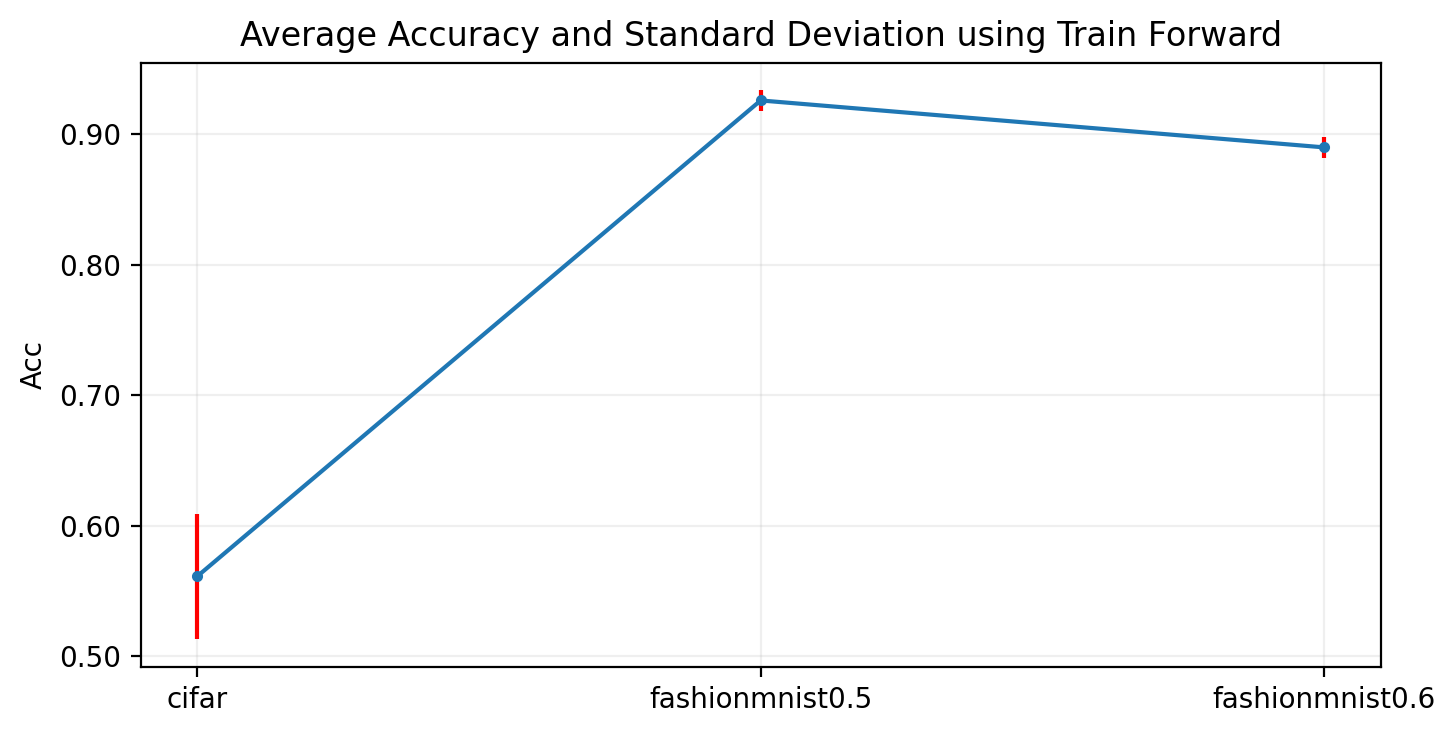

In [ ]:
from matplotlib.ticker import FormatStrFormatter

dict_mean = {}
dict_std = {}
for k, v in test_acc_forward_results.items():
  dict_mean[k] = round(np.mean(v), 3)
  dict_std[k] = round(np.std(v), 3)

fig = plt.figure(figsize=(8, 4), dpi=200)
ax = fig.add_subplot(111)
plt.title('Average Accuracy and Standard Deviation using Train Forward')
plt.ylabel("Acc")
plt.errorbar(test_acc_forward_results.keys(), dict_mean.values(), dict_std.values(), ecolor="red", marker='.')
plt.grid(alpha=0.2) 

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Train baseline using CNN classifier

In [ ]:
n_iters = 10
test_acc_baseline_results = {'cifar': [],
              'fashionmnist0.5': [],
              'fashionmnist0.6': []}

## Train on fmnist05

In [ ]:
# Some global variabiles
data_path = fmnist05_path
device = None
train_loader = None
model = None
model_config = OrderedDict([
    ('model_name','Predefined_CNNNet')
])

optim_config = OrderedDict([
    ('epochs', 10),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])


run_config = OrderedDict([
    ('seed', 1),
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])


for i in range(n_iters):   
  print(f"Iter: {i}")
  seed_torch(random.randrange(100))   
  run_train_val()

  outputs, y_true, y_pred, acc = predict()
  test_acc_baseline_results['fashionmnist0.5'].append(acc)
  print(f"\nAccuracy of Test data: {acc}\n")



Iter: 0
Train epoch  1  Accuracy  35.486111111111114
Validate epoch  1  Accuracy  38.5
Train epoch  2  Accuracy  42.236111111111114
Validate epoch  2  Accuracy  42.75
Train epoch  3  Accuracy  46.25
Validate epoch  3  Accuracy  47.166666666666664
Train epoch  4  Accuracy  46.5
Validate epoch  4  Accuracy  47.138888888888886
Train epoch  5  Accuracy  47.270833333333336
Validate epoch  5  Accuracy  47.52777777777778
Train epoch  6  Accuracy  47.44444444444444
Validate epoch  6  Accuracy  48.27777777777778
Train epoch  7  Accuracy  47.55555555555556
Validate epoch  7  Accuracy  48.083333333333336
Train epoch  8  Accuracy  47.9375
Validate epoch  8  Accuracy  48.0
Train epoch  9  Accuracy  47.979166666666664
Validate epoch  9  Accuracy  48.25
Train epoch  10  Accuracy  48.03472222222222
Validate epoch  10  Accuracy  48.5

Accuracy of Test data: 0.9266666666666666

Iter: 1
Train epoch  1  Accuracy  34.81944444444444
Validate epoch  1  Accuracy  38.333333333333336
Train epoch  2  Accuracy  4

## Train on fmnist06

In [ ]:
# Some global variabiles
data_path = fmnist06_path
device = None
train_loader = None
model = None
model_config = OrderedDict([
    ('model_name','Predefined_CNNNet')
])

optim_config = OrderedDict([
    ('epochs', 10),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])


run_config = OrderedDict([
    ('seed', 1),
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])


for i in range(n_iters):   
  print(f"Iter: {i}")
  seed_torch(random.randrange(100))   
  run_train_val()

  outputs, y_true, y_pred, acc = predict()
  test_acc_baseline_results['fashionmnist0.6'].append(acc)
  print(f"\nAccuracy of Test data: {acc}\n")


Iter: 0
Train epoch  1  Accuracy  34.208333333333336
Validate epoch  1  Accuracy  33.083333333333336
Train epoch  2  Accuracy  34.53472222222222
Validate epoch  2  Accuracy  35.77777777777778
Train epoch  3  Accuracy  36.291666666666664
Validate epoch  3  Accuracy  36.888888888888886
Train epoch  4  Accuracy  37.44444444444444
Validate epoch  4  Accuracy  38.861111111111114
Train epoch  5  Accuracy  37.94444444444444
Validate epoch  5  Accuracy  37.666666666666664
Train epoch  6  Accuracy  38.53472222222222
Validate epoch  6  Accuracy  39.30555555555556
Train epoch  7  Accuracy  38.69444444444444
Validate epoch  7  Accuracy  39.361111111111114
Train epoch  8  Accuracy  38.895833333333336
Validate epoch  8  Accuracy  38.388888888888886
Train epoch  9  Accuracy  39.236111111111114
Validate epoch  9  Accuracy  39.361111111111114
Train epoch  10  Accuracy  39.27777777777778
Validate epoch  10  Accuracy  39.666666666666664

Accuracy of Test data: 0.883

Iter: 1
Train epoch  1  Accuracy  33.

## Train on Cifar

In [ ]:
# Some global variabiles
data_path = cifar_path
device = None
train_loader = None
model = None
model_config = OrderedDict([
    ('model_name','Predefined_CNNNet_color'),
    ('input_dim',3)
])

optim_config = OrderedDict([
    ('epochs', 10),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])


run_config = OrderedDict([
    ('seed', 1),
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])
            

for i in range(n_iters):   
  print(f"Iter: {i}")
  seed_torch(random.randrange(100))   
  run_train_val()

  outputs, y_true, y_pred, acc = predict()
  test_acc_baseline_results['cifar'].append(acc)
  print(f"\nAccuracy of Test data: {acc}\n")


Iter: 0
Train epoch  1  Accuracy  33.3
Validate epoch  1  Accuracy  33.333333333333336
Train epoch  2  Accuracy  34.391666666666666
Validate epoch  2  Accuracy  33.96666666666667
Train epoch  3  Accuracy  33.28333333333333
Validate epoch  3  Accuracy  31.166666666666668
Train epoch  4  Accuracy  34.95
Validate epoch  4  Accuracy  32.56666666666667
Train epoch  5  Accuracy  35.333333333333336
Validate epoch  5  Accuracy  35.233333333333334
Train epoch  6  Accuracy  35.483333333333334
Validate epoch  6  Accuracy  32.53333333333333
Train epoch  7  Accuracy  35.925
Validate epoch  7  Accuracy  36.833333333333336
Train epoch  8  Accuracy  37.09166666666667
Validate epoch  8  Accuracy  37.4
Train epoch  9  Accuracy  36.56666666666667
Validate epoch  9  Accuracy  35.13333333333333
Train epoch  10  Accuracy  36.516666666666666
Validate epoch  10  Accuracy  36.233333333333334

Accuracy of Test data: 0.5496666666666666

Iter: 1
Train epoch  1  Accuracy  33.31666666666667
Validate epoch  1  Accur

## Save baseline results

In [ ]:
# Copy values
test_acc_baseline_results_backup = test_acc_baseline_results 

# Create dataframe from dictionary
df = pd.DataFrame(test_acc_baseline_results)
print(df)


# Save results
import pickle
with open('/content/drive/MyDrive/COMP5328-A2/backup/test_acc_baseline_results.pkl', 'wb') as fp:
    pickle.dump(test_acc_baseline_results, fp, protocol=pickle.HIGHEST_PROTOCOL)


      cifar  fashionmnist0.5  fashionmnist0.6
0  0.549667         0.926667         0.883000
1  0.560000         0.911333         0.866000
2  0.522000         0.904667         0.890333
3  0.560000         0.922667         0.880333
4  0.533000         0.908333         0.869000
5  0.494667         0.917333         0.859000
6  0.550333         0.926667         0.838667
7  0.607000         0.920000         0.881000
8  0.493000         0.901667         0.888667
9  0.570000         0.917667         0.874000


In [ ]:
with open('/content/drive/MyDrive/COMP5328-A2/backup/test_acc_baseline_results.pkl', 'rb') as fp:
    test_load = pickle.load(fp)

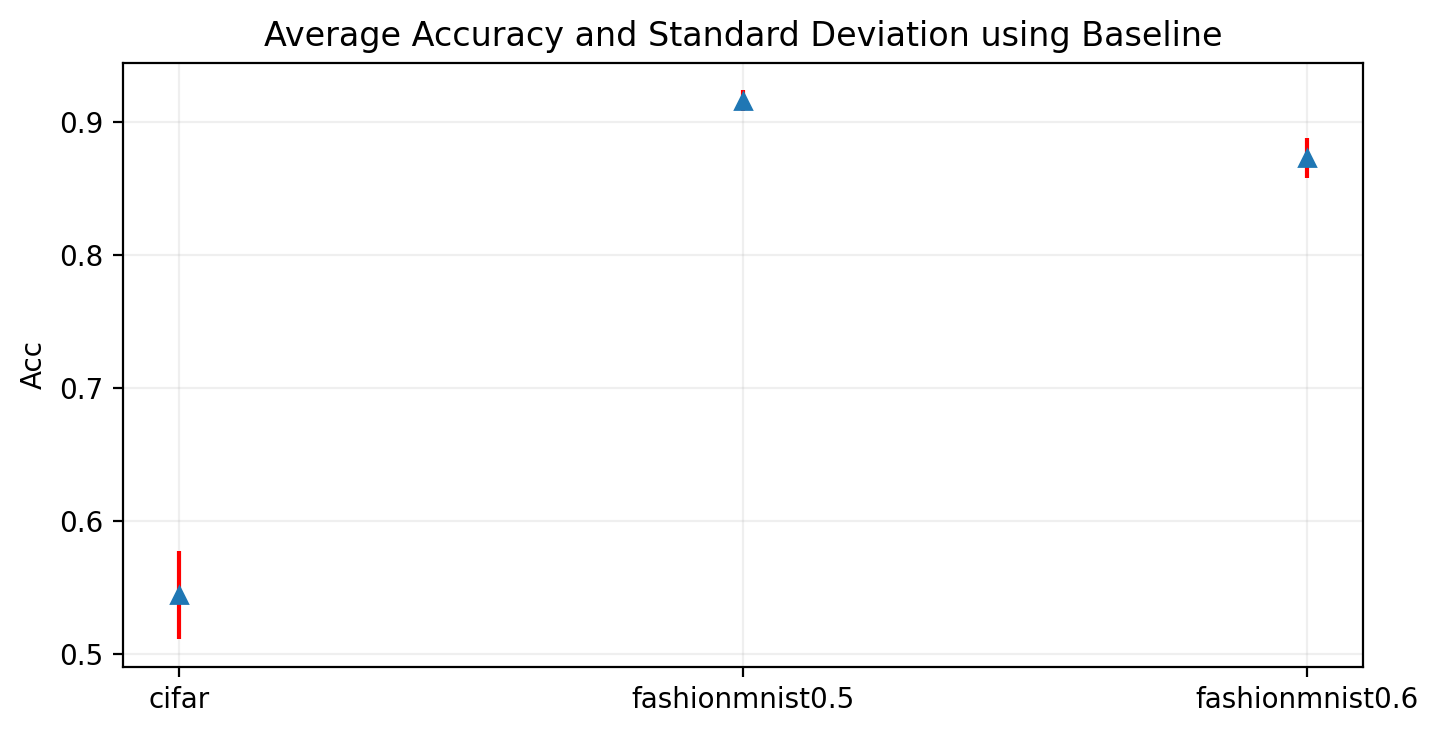

In [ ]:
test_acc_baseline_results = test_load

dict_mean = {}
dict_std = {}
for k, v in test_acc_baseline_results.items():
  dict_mean[k] = round(np.mean(v), 3)
  dict_std[k] = round(np.std(v), 3)

plt.figure(figsize=(8, 4), dpi=200)
plt.title('Average Accuracy and Standard Deviation using Baseline')
plt.ylabel("Acc")
plt.errorbar(test_acc_baseline_results.keys(), dict_mean.values(), dict_std.values(), 
             ecolor=["red"], linestyle='None', marker='^')
plt.grid(alpha=0.2) 

# Compare Acc and Std between baseline and forward method

{'cifar': 0.561, 'fashionmnist0.5': 0.926, 'fashionmnist0.6': 0.89}
{'cifar': 0.048, 'fashionmnist0.5': 0.008, 'fashionmnist0.6': 0.008}
{'cifar': 0.544, 'fashionmnist0.5': 0.916, 'fashionmnist0.6': 0.873}
{'cifar': 0.033, 'fashionmnist0.5': 0.008, 'fashionmnist0.6': 0.015}


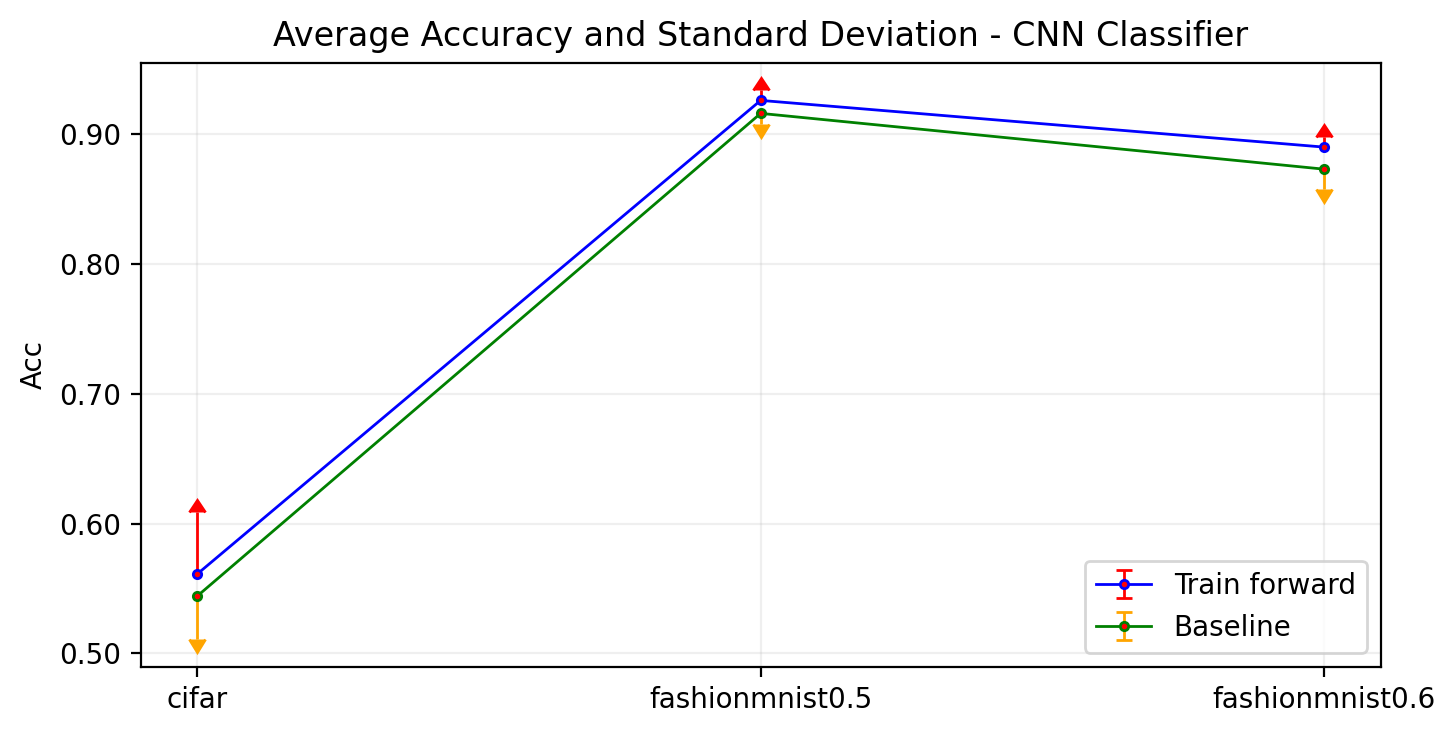

In [ ]:
from matplotlib.ticker import FormatStrFormatter

dict_mean_forward = {}
dict_std_forward = {}
for k, v in test_acc_forward_results.items():
  dict_mean_forward[k] = round(np.mean(v), 3)
  dict_std_forward[k] = round(np.std(v), 3)

print(dict_mean_forward)
print(dict_std_forward)

dict_mean_baseline = {}
dict_std_baseline = {}
for k, v in test_acc_baseline_results.items():
  dict_mean_baseline[k] = round(np.mean(v), 3)
  dict_std_baseline[k] = round(np.std(v), 3)

print(dict_mean_baseline)
print(dict_std_baseline)

fig = plt.figure(figsize=(8, 4), dpi=200)
ax = fig.add_subplot(111)
plt.title('Average Accuracy and Standard Deviation - CNN Classifier')
plt.ylabel("Acc")
plt.errorbar(test_acc_forward_results.keys(), dict_mean_forward.values(), dict_std_forward.values(), lolims=True, ecolor='red',mfc='red', color='blue', marker='.',linewidth=1, label='Train forward')
plt.errorbar(test_acc_baseline_results.keys(), dict_mean_baseline.values(), dict_std_baseline.values(),uplims=True,ecolor='orange',mfc='red', color='green', marker='.',linewidth=1, label='Baseline')
plt.grid(alpha=0.2) 
plt.legend(loc='lower right')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Train forward using FCN classifier

In [ ]:
n_iters = 10
test_acc_forward_fcn_results = {'cifar': [],
              'fashionmnist0.5': [],
              'fashionmnist0.6': []}

## Train on Cifar

In [ ]:
class FCNet_color(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=100, output_dim=3):
        super(FCNet_color, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # TODO based on the class attributes (fields), define a fully connected network with one hidden layer.
        # Specifically, it should have this structure:
        # input_layer->relu->hidden_layer->relu->output_layer.
        out = F.relu(self.input_layer(x.reshape(-1, 3*32*32)))
        out = F.relu(self.hidden_layer(out))
        out = self.output_layer(out)
        return out
    
def Predefined_FCNet_forward(input_dim=3*32*32, hidden_dim=256, output_dim=3):
    model = FCNet_color(input_dim=input_dim,hidden_dim=hidden_dim,output_dim=output_dim)
    return model


def run_train_val_forward():
    global device
    global config
    global train_loader
    global test_loader
    global model

    best_top1_acc = 0
    T_mat = estimated_T_cifar

    # check gpu
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # configerations
    run_config = config['run_config']
    optim_config = config['optim_config']
    data_config = config['data_config']
    
    # # set random seed
    # seed_torch(random.randrange(100))

    # create output directory
    outdir = run_config['outdir']
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # load data
    data = np.load(data_config["data_path"])
    
    train_loader, val_loader, test_loader = get_loader(
        batch_size = optim_config['batch_size'], 
        num_workers = run_config['num_workers'],
        val_split = data_config['val_split'],
        data = data
    )
    
    # model
    model = load_model(config['model_config'])
    if torch.cuda.device_count() > 1:
        print(torch.cuda.device_count(), "GPUs are used!")
        model = nn.DataParallel(model)
    model.to(device)

    # criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        params = model.parameters(),
        lr = optim_config['base_lr'], 
        momentum = optim_config['momentum'],
        weight_decay = optim_config['weight_decay']
    )

    for epoch in range(1, optim_config['epochs'] + 1):

        #train
        train_forward(epoch, model, optimizer, T_mat,  criterion, train_loader)

        #validation
        top1_acc_avg = validate_and_test_forward(epoch, model, T_mat, criterion, val_loader)
        
        # save the best model so far
        if (top1_acc_avg > best_top1_acc):
            state = OrderedDict([
                ('config', config),
                ('state_dict', model.state_dict()),
                ('optimizer', optimizer.state_dict()),
                ('epoch', epoch),
                ('top1-accuracy', top1_acc_avg),
            ])
            best_model_path = os.path.join(outdir, 'model_best.pth')
            torch.save(state, best_model_path)
            best_top1_acc = top1_acc_avg


# Some global variabiles
data_path = cifar_path
device = None
train_loader = None
model = None
model_config = OrderedDict([
    ('model_name','Predefined_FCNet_forward')
])

optim_config = OrderedDict([
    ('epochs', 20),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])


run_config = OrderedDict([
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])


for i in range(n_iters):   
  print(f"Iter: {i}")
  seed_torch(random.randrange(100))   
  run_train_val()

  outputs, y_true, y_pred, acc = predict()
  test_acc_forward_fcn_results['cifar'].append(acc)
  print(f"\nAccuracy of Test data: {acc}\n")

Iter: 0
Train epoch  1  Accuracy  34.475
Validate epoch  1  Accuracy  35.1
Train epoch  2  Accuracy  35.53333333333333
Validate epoch  2  Accuracy  34.5
Train epoch  3  Accuracy  35.766666666666666
Validate epoch  3  Accuracy  36.03333333333333
Train epoch  4  Accuracy  36.541666666666664
Validate epoch  4  Accuracy  36.233333333333334
Train epoch  5  Accuracy  37.19166666666667
Validate epoch  5  Accuracy  36.56666666666667
Train epoch  6  Accuracy  36.99166666666667
Validate epoch  6  Accuracy  34.96666666666667
Train epoch  7  Accuracy  37.266666666666666
Validate epoch  7  Accuracy  36.53333333333333
Train epoch  8  Accuracy  37.325
Validate epoch  8  Accuracy  35.166666666666664
Train epoch  9  Accuracy  37.50833333333333
Validate epoch  9  Accuracy  33.96666666666667
Train epoch  10  Accuracy  37.4
Validate epoch  10  Accuracy  36.4
Train epoch  11  Accuracy  37.09166666666667
Validate epoch  11  Accuracy  34.3
Train epoch  12  Accuracy  37.81666666666667
Validate epoch  12  Accu

## Train on fashionmnist05

In [ ]:
def Predefined_FCNet_forward(input_dim=28*28, hidden_dim=256, output_dim=3):
    model = FCNet(input_dim=input_dim,hidden_dim=hidden_dim,output_dim=output_dim)
    return model

def run_train_val_forward():
    global device
    global config
    global train_loader
    global test_loader
    global model

    best_top1_acc = 0
    T_mat = T_matrix['FasionMNIST_05']

    # check gpu
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # configerations
    run_config = config['run_config']
    optim_config = config['optim_config']
    data_config = config['data_config']
    
    # set random seed
    # seed_torch(random.randrange(10))

    # create output directory
    outdir = run_config['outdir']
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # load data
    data = np.load(data_config["data_path"])
    
    train_loader, val_loader, test_loader = get_loader(
        batch_size = optim_config['batch_size'], 
        num_workers = run_config['num_workers'],
        val_split = data_config['val_split'],
        data = data
    )
    
    # model
    model = load_model(config['model_config'])
    if torch.cuda.device_count() > 1:
        print(torch.cuda.device_count(), "GPUs are used!")
        model = nn.DataParallel(model)
    model.to(device)

    # criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        params = model.parameters(),
        lr = optim_config['base_lr'], 
        momentum = optim_config['momentum'],
        weight_decay = optim_config['weight_decay']
    )

    for epoch in range(1, optim_config['epochs'] + 1):

        #train
        train_forward(epoch, model, optimizer, T_mat,  criterion, train_loader)

        #validation
        top1_acc_avg = validate_and_test_forward(epoch, model, T_mat, criterion, val_loader)
        
        # save the best model so far
        if (top1_acc_avg > best_top1_acc):
            state = OrderedDict([
                ('config', config),
                ('state_dict', model.state_dict()),
                ('optimizer', optimizer.state_dict()),
                ('epoch', epoch),
                ('top1-accuracy', top1_acc_avg),
            ])
            best_model_path = os.path.join(outdir, 'model_best.pth')
            torch.save(state, best_model_path)
            best_top1_acc = top1_acc_avg


# Some global variabiles
data_path = fmnist05_path
device = None
train_loader = None
model = None
model_config = OrderedDict([
    ('model_name','Predefined_FCNet_forward')
])

optim_config = OrderedDict([
    ('epochs', 20),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])


run_config = OrderedDict([
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])
            

for i in range(n_iters):    
  seed_torch(random.randrange(100))  
  run_train_val_forward()

  outputs, y_true, y_pred, acc = predict()
  test_acc_forward_fcn_results['fashionmnist0.5'].append(acc)
  print(f"\nAccuracy of Test data: {acc}")

Train epoch  1  Accuracy  45.576388888888886
Validate epoch  1  Accuracy  47.861111111111114
Train epoch  2  Accuracy  47.451388888888886
Validate epoch  2  Accuracy  48.02777777777778
Train epoch  3  Accuracy  48.0
Validate epoch  3  Accuracy  48.361111111111114
Train epoch  4  Accuracy  48.173611111111114
Validate epoch  4  Accuracy  48.138888888888886
Train epoch  5  Accuracy  48.0625
Validate epoch  5  Accuracy  48.0
Train epoch  6  Accuracy  48.59027777777778
Validate epoch  6  Accuracy  48.166666666666664
Train epoch  7  Accuracy  48.53472222222222
Validate epoch  7  Accuracy  48.22222222222222
Train epoch  8  Accuracy  48.22222222222222
Validate epoch  8  Accuracy  48.44444444444444
Train epoch  9  Accuracy  48.68055555555556
Validate epoch  9  Accuracy  48.388888888888886
Train epoch  10  Accuracy  48.84722222222222
Validate epoch  10  Accuracy  48.05555555555556
Train epoch  11  Accuracy  48.97222222222222
Validate epoch  11  Accuracy  48.69444444444444
Train epoch  12  Accura

## Train on fashionmnist06

In [ ]:
def Predefined_FCNet_forward(input_dim=28*28, hidden_dim=256, output_dim=3):
    model = FCNet(input_dim=input_dim,hidden_dim=hidden_dim,output_dim=output_dim)
    return model

def run_train_val_forward():
    global device
    global config
    global train_loader
    global test_loader
    global model

    best_top1_acc = 0
    T_mat = T_matrix['FasionMNIST_06']

    # check gpu
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # configerations
    run_config = config['run_config']
    optim_config = config['optim_config']
    data_config = config['data_config']
    
    # set random seed
    # seed_torch(random.randrange(10))

    # create output directory
    outdir = run_config['outdir']
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # load data
    data = np.load(data_config["data_path"])
    
    train_loader, val_loader, test_loader = get_loader(
        batch_size = optim_config['batch_size'], 
        num_workers = run_config['num_workers'],
        val_split = data_config['val_split'],
        data = data
    )
    
    # model
    model = load_model(config['model_config'])
    if torch.cuda.device_count() > 1:
        print(torch.cuda.device_count(), "GPUs are used!")
        model = nn.DataParallel(model)
    model.to(device)

    # criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        params = model.parameters(),
        lr = optim_config['base_lr'], 
        momentum = optim_config['momentum'],
        weight_decay = optim_config['weight_decay']
    )

    for epoch in range(1, optim_config['epochs'] + 1):

        #train
        train_forward(epoch, model, optimizer, T_mat,  criterion, train_loader)

        #validation
        top1_acc_avg = validate_and_test_forward(epoch, model, T_mat, criterion, val_loader)
        
        # save the best model so far
        if (top1_acc_avg > best_top1_acc):
            state = OrderedDict([
                ('config', config),
                ('state_dict', model.state_dict()),
                ('optimizer', optimizer.state_dict()),
                ('epoch', epoch),
                ('top1-accuracy', top1_acc_avg),
            ])
            best_model_path = os.path.join(outdir, 'model_best.pth')
            torch.save(state, best_model_path)
            best_top1_acc = top1_acc_avg

# Some global variabiles
data_path = fmnist06_path
device = None
train_loader = None
model = None
model_config = OrderedDict([
    ('model_name','Predefined_FCNet_forward')
])

optim_config = OrderedDict([
    ('epochs', 20),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])


run_config = OrderedDict([
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])
            

for i in range(n_iters):    
  seed_torch(random.randrange(100))  
  run_train_val_forward()

  outputs, y_true, y_pred, acc = predict()
  test_acc_forward_fcn_results['fashionmnist0.6'].append(acc)
  print(f"\nAccuracy of Test data: {acc}")

Train epoch  1  Accuracy  37.048611111111114
Validate epoch  1  Accuracy  39.02777777777778
Train epoch  2  Accuracy  38.4375
Validate epoch  2  Accuracy  38.69444444444444
Train epoch  3  Accuracy  39.048611111111114
Validate epoch  3  Accuracy  39.111111111111114
Train epoch  4  Accuracy  39.388888888888886
Validate epoch  4  Accuracy  39.19444444444444
Train epoch  5  Accuracy  39.354166666666664
Validate epoch  5  Accuracy  39.52777777777778
Train epoch  6  Accuracy  39.520833333333336
Validate epoch  6  Accuracy  39.44444444444444
Train epoch  7  Accuracy  39.40277777777778
Validate epoch  7  Accuracy  39.47222222222222
Train epoch  8  Accuracy  39.666666666666664
Validate epoch  8  Accuracy  38.94444444444444
Train epoch  9  Accuracy  39.72222222222222
Validate epoch  9  Accuracy  39.5
Train epoch  10  Accuracy  39.78472222222222
Validate epoch  10  Accuracy  39.5
Train epoch  11  Accuracy  39.729166666666664
Validate epoch  11  Accuracy  39.19444444444444
Train epoch  12  Accura

## Save train forward results

In [ ]:
# Copy values
test_acc_forward_fcn_results_backup = test_acc_forward_fcn_results 

# Create dataframe from dictionary
df = pd.DataFrame(test_acc_forward_fcn_results)
print(df)


# Save results
import pickle
with open('/content/drive/MyDrive/COMP5328-A2/backup/test_acc_forward_fcn_results.pkl', 'wb') as fp:
    pickle.dump(test_acc_forward_fcn_results, fp, protocol=pickle.HIGHEST_PROTOCOL)


      cifar  fashionmnist0.5  fashionmnist0.6
0  0.477667         0.930000         0.894000
1  0.542000         0.905667         0.870667
2  0.626000         0.919000         0.886667
3  0.504667         0.926667         0.884000
4  0.560667         0.928000         0.897667
5  0.581000         0.923000         0.881333
6  0.632667         0.914000         0.885000
7  0.606000         0.925000         0.886667
8  0.555333         0.911333         0.874667
9  0.590333         0.910000         0.887333


In [ ]:
with open('/content/drive/MyDrive/COMP5328-A2/backup/test_acc_forward_fcn_results.pkl', 'rb') as fp:
    test_load = pickle.load(fp)

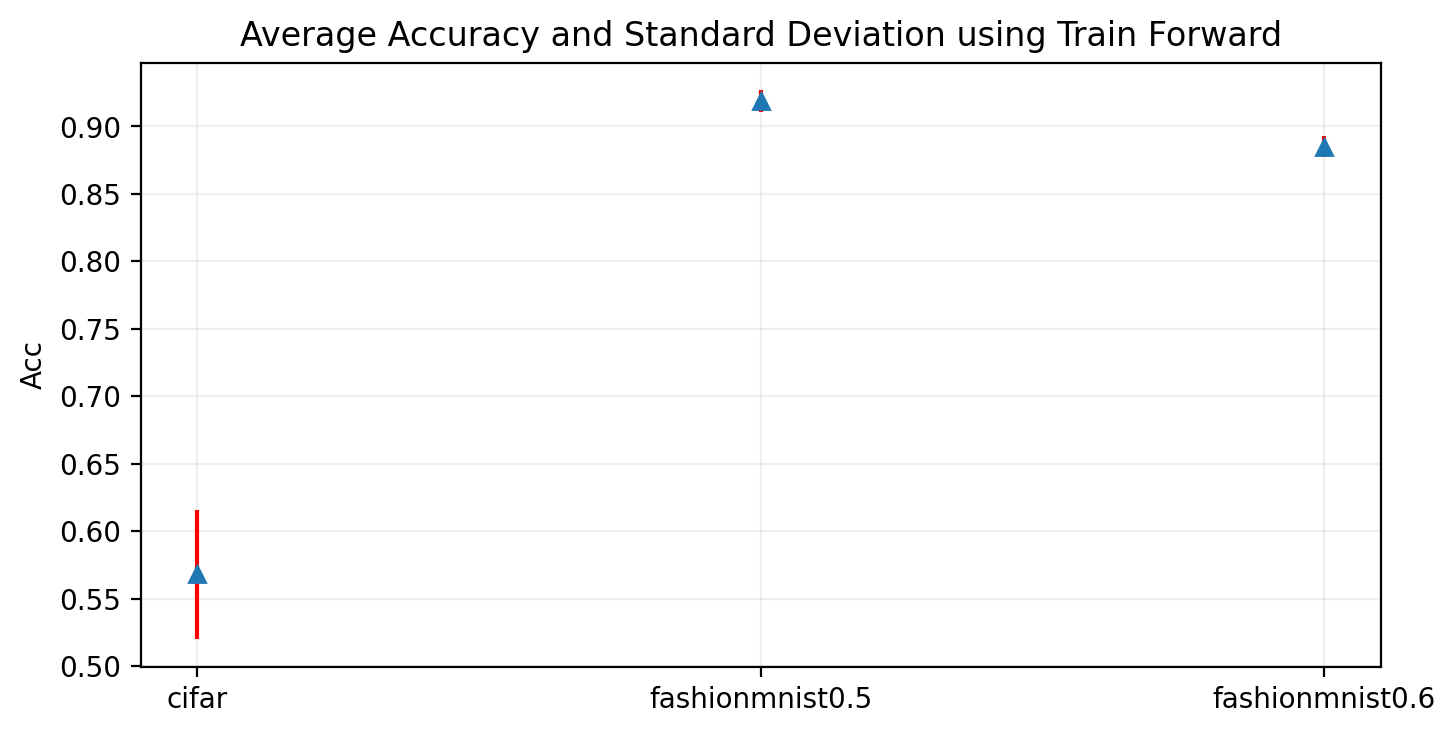

In [ ]:
test_acc_forward_fcn_results = test_load

dict_mean = {}
dict_std = {}
for k, v in test_acc_forward_fcn_results.items():
  dict_mean[k] = round(np.mean(v), 3)
  dict_std[k] = round(np.std(v), 3)

plt.figure(figsize=(8, 4), dpi=200)
plt.title('Average Accuracy and Standard Deviation using Train Forward')
plt.ylabel("Acc")
plt.errorbar(test_acc_forward_fcn_results.keys(), dict_mean.values(), dict_std.values(), 
             ecolor=["red"], linestyle='None', marker='^')
plt.grid(alpha=0.2) 

# Train baseline using FCN classifier

In [ ]:
n_iters = 10
test_acc_baseline_fcn_results = {'cifar': [],
              'fashionmnist0.5': [],
              'fashionmnist0.6': []}

## Train on fashionmnist05

In [ ]:
# Some global variabiles
data_path = fmnist05_path
device = None
train_loader = None
model = None
model_config = OrderedDict([
    ('model_name','Predefined_FCNet')
])

optim_config = OrderedDict([
    ('epochs', 10),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])

run_config = OrderedDict([
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])


for i in range(n_iters): 
  print(f"Iter: {i}")   
  seed_torch(random.randrange(100))  
  run_train_val()

  outputs, y_true, y_pred, acc = predict()
  test_acc_baseline_fcn_results['fashionmnist0.5'].append(acc)
  print(f"\nAccuracy of Test data: {acc}")


Iter: 0
Train epoch  1  Accuracy  45.15972222222222
Validate epoch  1  Accuracy  47.861111111111114
Train epoch  2  Accuracy  47.708333333333336
Validate epoch  2  Accuracy  48.0
Train epoch  3  Accuracy  47.791666666666664
Validate epoch  3  Accuracy  48.30555555555556
Train epoch  4  Accuracy  47.88194444444444
Validate epoch  4  Accuracy  46.083333333333336
Train epoch  5  Accuracy  48.138888888888886
Validate epoch  5  Accuracy  48.138888888888886
Train epoch  6  Accuracy  48.041666666666664
Validate epoch  6  Accuracy  47.611111111111114
Train epoch  7  Accuracy  48.27777777777778
Validate epoch  7  Accuracy  48.333333333333336
Train epoch  8  Accuracy  48.34722222222222
Validate epoch  8  Accuracy  47.916666666666664
Train epoch  9  Accuracy  48.77777777777778
Validate epoch  9  Accuracy  47.5
Train epoch  10  Accuracy  48.34722222222222
Validate epoch  10  Accuracy  48.166666666666664

Accuracy of Test data: 0.923
Iter: 1
Train epoch  1  Accuracy  45.0
Validate epoch  1  Accurac

## Train on fashionmnist06

In [ ]:
# Some global variabiles
data_path = fmnist06_path
device = None
train_loader = None
model = None
model_config = OrderedDict([
    ('model_name','Predefined_FCNet')
])

optim_config = OrderedDict([
    ('epochs', 10),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])

run_config = OrderedDict([
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])


for i in range(n_iters): 
  print(f"Iter: {i}")   
  seed_torch(random.randrange(100))  
  run_train_val()

  outputs, y_true, y_pred, acc = predict()
  test_acc_baseline_fcn_results['fashionmnist0.6'].append(acc)
  print(f"\nAccuracy of Test data: {acc}\n")


Iter: 0
Train epoch  1  Accuracy  37.298611111111114
Validate epoch  1  Accuracy  39.47222222222222
Train epoch  2  Accuracy  38.763888888888886
Validate epoch  2  Accuracy  39.52777777777778
Train epoch  3  Accuracy  38.763888888888886
Validate epoch  3  Accuracy  39.02777777777778
Train epoch  4  Accuracy  38.798611111111114
Validate epoch  4  Accuracy  40.166666666666664
Train epoch  5  Accuracy  39.354166666666664
Validate epoch  5  Accuracy  40.416666666666664
Train epoch  6  Accuracy  39.44444444444444
Validate epoch  6  Accuracy  39.94444444444444
Train epoch  7  Accuracy  39.40972222222222
Validate epoch  7  Accuracy  39.72222222222222
Train epoch  8  Accuracy  39.145833333333336
Validate epoch  8  Accuracy  39.97222222222222
Train epoch  9  Accuracy  39.479166666666664
Validate epoch  9  Accuracy  38.861111111111114
Train epoch  10  Accuracy  39.666666666666664
Validate epoch  10  Accuracy  39.5

Accuracy of Test data: 0.8813333333333333

Iter: 1
Train epoch  1  Accuracy  37.0

## Train on Cifar

In [ ]:
# Define a fully connected network class.
class FCNet(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=100, output_dim=3):
        super(FCNet, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # TODO based on the class attributes (fields), define a fully connected network with one hidden layer.
        # Specifically, it should have this structure:
        # input_layer->relu->hidden_layer->relu->output_layer.
        out = F.relu(self.input_layer(x.reshape(-1, 3*32*32)))
        out = F.relu(self.hidden_layer(out))
        out = self.output_layer(out)
        return out
        
    
def Predefined_FCNet(input_dim=3*32*32, hidden_dim=256, output_dim=3):
    model = FCNet(input_dim=input_dim,hidden_dim=hidden_dim,output_dim=output_dim)
    return model



# Some global variabiles
data_path = cifar_path
device = None
train_loader = None
model = None
model_config = OrderedDict([
    ('model_name','Predefined_FCNet')
])

optim_config = OrderedDict([
    ('epochs', 10),
    ('batch_size', 64),
    ('base_lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.001)
])

run_config = OrderedDict([
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

data_config = OrderedDict([
    ('data_path', data_path),
    ('val_split', 0.2)
]) 

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('run_config', run_config),
    ('data_config', data_config)
])


for i in range(n_iters): 
  print(f"Iter: {i}")   
  seed_torch(random.randrange(100))  
  run_train_val()

  outputs, y_true, y_pred, acc = predict()
  test_acc_baseline_fcn_results['cifar'].append(acc)
  print(f"\nAccuracy of Test data: {acc}\n")


Iter: 0
Train epoch  1  Accuracy  34.13333333333333
Validate epoch  1  Accuracy  33.333333333333336
Train epoch  2  Accuracy  35.925
Validate epoch  2  Accuracy  36.86666666666667
Train epoch  3  Accuracy  36.43333333333333
Validate epoch  3  Accuracy  36.3
Train epoch  4  Accuracy  36.5
Validate epoch  4  Accuracy  33.13333333333333
Train epoch  5  Accuracy  36.68333333333333
Validate epoch  5  Accuracy  35.13333333333333
Train epoch  6  Accuracy  37.19166666666667
Validate epoch  6  Accuracy  36.7
Train epoch  7  Accuracy  36.53333333333333
Validate epoch  7  Accuracy  35.9
Train epoch  8  Accuracy  37.108333333333334
Validate epoch  8  Accuracy  36.233333333333334
Train epoch  9  Accuracy  37.166666666666664
Validate epoch  9  Accuracy  35.56666666666667
Train epoch  10  Accuracy  37.291666666666664
Validate epoch  10  Accuracy  35.5

Accuracy of Test data: 0.5406666666666666

Iter: 1
Train epoch  1  Accuracy  33.53333333333333
Validate epoch  1  Accuracy  34.0
Train epoch  2  Accur

## Save baseline results

In [ ]:
# Copy values
test_acc_baseline_fcn_results_backup = test_acc_baseline_fcn_results 

# Create dataframe from dictionary
df = pd.DataFrame(test_acc_baseline_fcn_results)
print(df)


# Save results
import pickle
with open('/content/drive/MyDrive/COMP5328-A2/backup/test_acc_baseline_fcn_results.pkl', 'wb') as fp:
    pickle.dump(test_acc_baseline_fcn_results, fp, protocol=pickle.HIGHEST_PROTOCOL)


      cifar  fashionmnist0.5  fashionmnist0.6
0  0.540667         0.923000         0.881333
1  0.570333         0.901000         0.885000
2  0.576333         0.926333         0.886667
3  0.482000         0.921000         0.874667
4  0.590333         0.922333         0.887333
5  0.417333         0.920667         0.894000
6  0.587667         0.914667         0.886667
7  0.573000         0.902333         0.886667
8  0.504667         0.922667         0.884000
9  0.560667         0.915000         0.897667


In [ ]:
with open('/content/drive/MyDrive/COMP5328-A2/backup/test_acc_baseline_fcn_results.pkl', 'rb') as fp:
    test_load = pickle.load(fp)

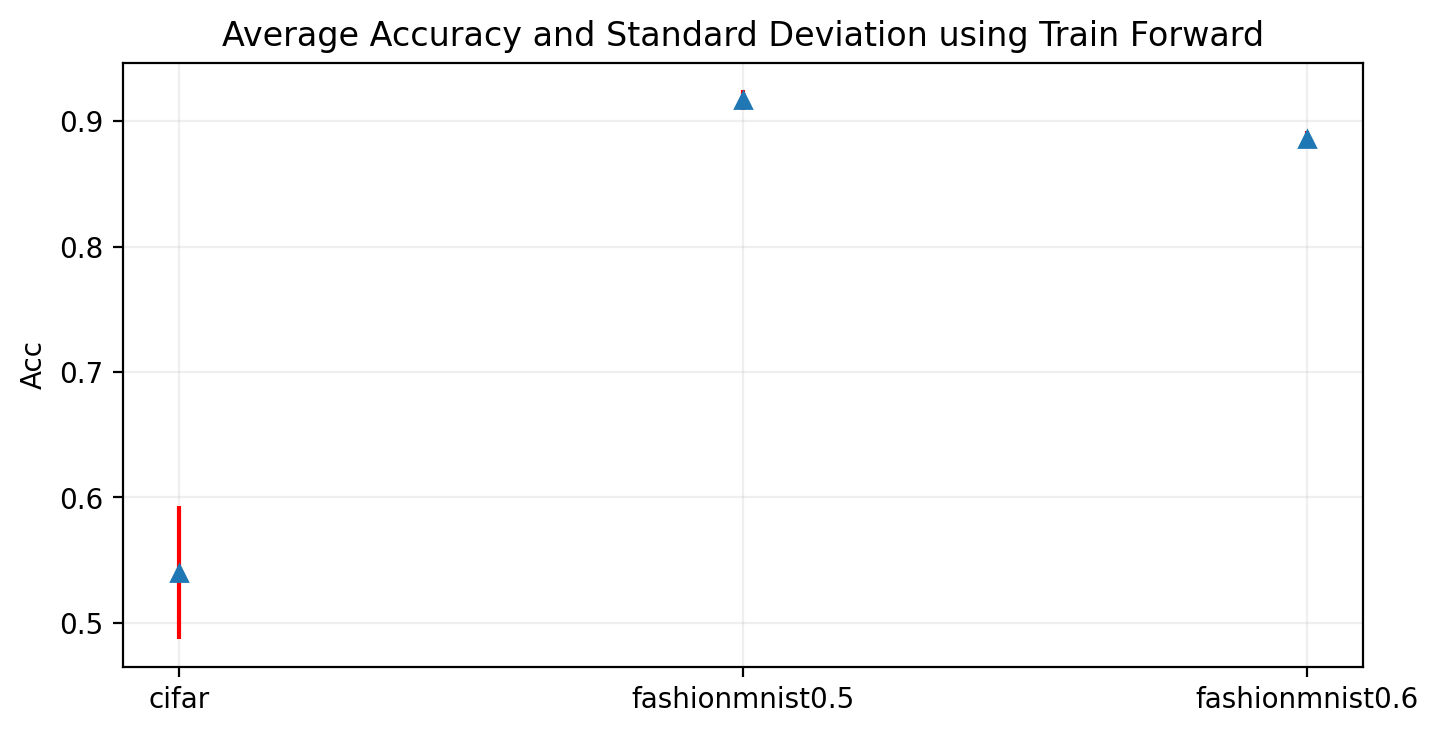

In [ ]:
test_acc_baseline_fcn_results = test_load

dict_mean = {}
dict_std = {}
for k, v in test_acc_baseline_fcn_results.items():
  dict_mean[k] = round(np.mean(v), 3)
  dict_std[k] = round(np.std(v), 3)

plt.figure(figsize=(8, 4), dpi=200)
plt.title('Average Accuracy and Standard Deviation using Train Forward')
plt.ylabel("Acc")
plt.errorbar(test_acc_baseline_fcn_results.keys(), dict_mean.values(), dict_std.values(), 
             ecolor=["red"], linestyle='None', marker='^')
plt.grid(alpha=0.2) 

# Compare Acc and Std between baselien and Forward method

{'cifar': 0.568, 'fashionmnist0.5': 0.919, 'fashionmnist0.6': 0.885}
{'cifar': 0.048, 'fashionmnist0.5': 0.008, 'fashionmnist0.6': 0.008}
{'cifar': 0.54, 'fashionmnist0.5': 0.917, 'fashionmnist0.6': 0.886}
{'cifar': 0.053, 'fashionmnist0.5': 0.008, 'fashionmnist0.6': 0.006}


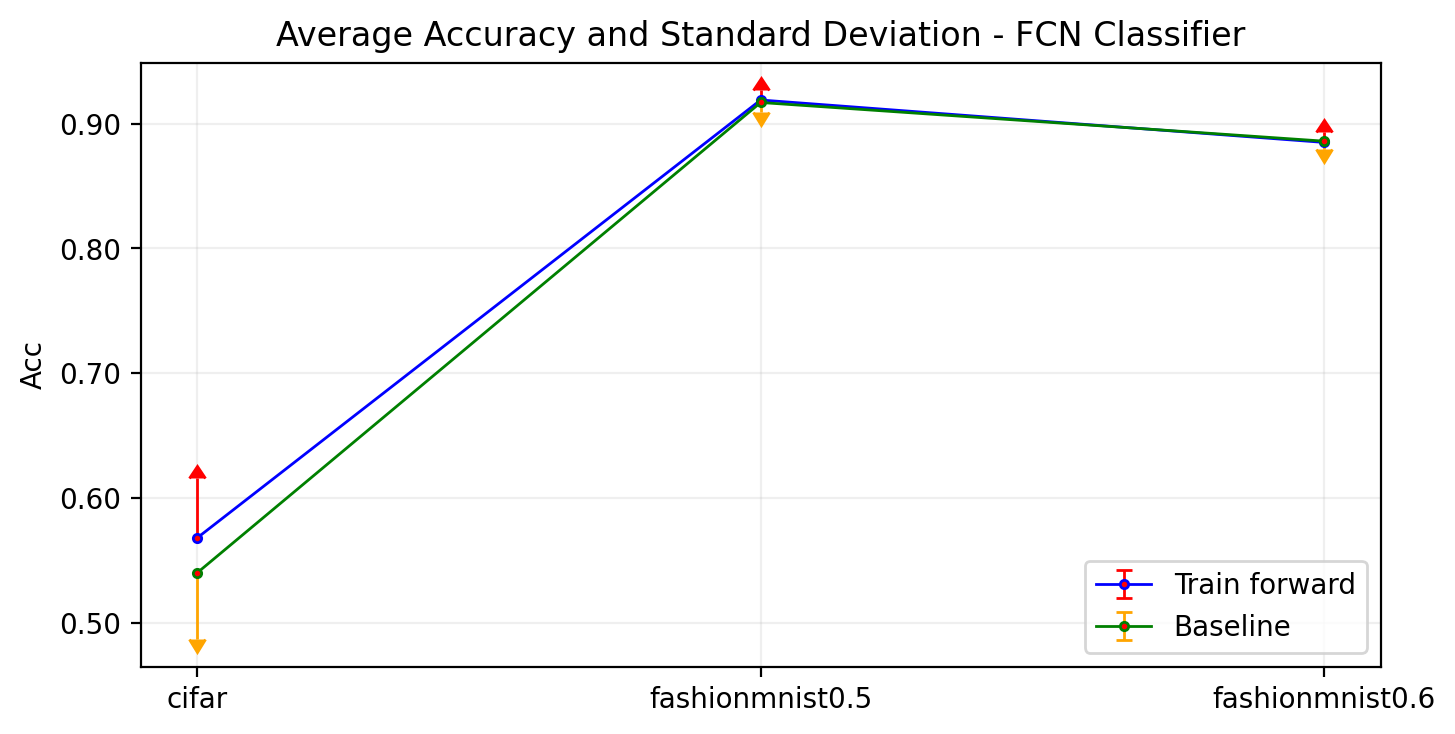

In [ ]:
from matplotlib.ticker import FormatStrFormatter

dict_mean_forward = {}
dict_std_forward = {}
for k, v in test_acc_forward_fcn_results.items():
  dict_mean_forward[k] = round(np.mean(v), 3)
  dict_std_forward[k] = round(np.std(v), 3)

print(dict_mean_forward)
print(dict_std_forward)

dict_mean_baseline = {}
dict_std_baseline = {}
for k, v in test_acc_baseline_fcn_results.items():
  dict_mean_baseline[k] = round(np.mean(v), 3)
  dict_std_baseline[k] = round(np.std(v), 3)

print(dict_mean_baseline)
print(dict_std_baseline)0.54

fig = plt.figure(figsize=(8, 4), dpi=200)
ax = fig.add_subplot(111)
plt.title('Average Accuracy and Standard Deviation - FCN Classifier')
plt.ylabel("Acc")
plt.errorbar(test_acc_forward_fcn_results.keys(), dict_mean_forward.values(), dict_std_forward.values(), lolims=True, ecolor='red',mfc='red', color='blue', marker='.',linewidth=1, label='Train forward')
plt.errorbar(test_acc_baseline_fcn_results.keys(), dict_mean_baseline.values(), dict_std_baseline.values(),uplims=True,ecolor='orange',mfc='red', color='green', marker='.',linewidth=1, label='Baseline')
plt.grid(alpha=0.2) 
plt.legend(loc='lower right')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))